# Shakespearean Transformer (nano-GPT) with BPE Tokenization

This hands-on exercise touches on building and training a miniature version of a Generative Pre-trained Transformer (GPT) model.

This notebook is heavily inspired by and simplifies Andrej Karpathy's [nanoGPT repository](https://github.com/karpathy/nanoGPT). The goal is to work on the basics needed to build a character-level language model on the works of Shakespeare.

**Why is this exciting?**
The Transformer architecture, is the foundation of modern Large Language Models (LLMs). While our model will be much smaller, the fundamental building blocks (like self-attention, positional embeddings, and decoder blocks) are conceptually very similar to those in models like GPT-3, which powered the original ChatGPT. Hopefully this helps gain deeper intuition for how these models work.

**Project outline:**
1.  **Data Preparation:** Load Shakespeare's text and create a character-level tokenizer.
2.  **Model Definition:** Implement the GPT architecture from scratch, including self-attention and transformer blocks.
3.  **Training:** Write a simple training loop to teach our model to predict the next character in a sequence.
4.  **Generation:** Use our trained model to generate new, Shakespeare-like text.

In [16]:
import os
import requests
import time
import math
from dataclasses import dataclass
import pickle # For saving/loading meta later if needed, though not strictly for tokenizer now
from collections import defaultdict, Counter
import re

import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm # For progress bars

# --- Hyperparameters ---
BATCH_SIZE = 64
BLOCK_SIZE = 256  # Context length
MAX_ITERS = 5000
EVAL_INTERVAL = 250
LEARNING_RATE = 3e-4 # Adjusted from 1e-3, often 3e-4 is a good starting point
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EMBD = 384
N_HEAD = 6
N_LAYER = 10
DROPOUT = 0.2
# AdamW optimizer betas
BETA1 = 0.9
BETA2 = 0.95
# Early stopping
EARLY_STOPPING_PATIENCE = 5 # Number of evaluation intervals to wait
EVAL_ITERS_FOR_LOSS = 100 # Number of batches to average for loss estimation

# For reproducibility
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1337)

print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Data Loading and Tokenization

The first step in any machine learning project is to prepare the data. For our character-level language model, this involves:
1.  **Downloading the Data:** We'll use the "Tiny Shakespeare" dataset, which contains a collection of Shakespeare's works.
2.  **Creating a Vocabulary:** We'll identify all unique characters present in the text. This set of unique characters will form our vocabulary.
3.  **Building a Tokenizer:** We'll create two simple functions:
    *   `encode`: Converts a string of characters into a list of corresponding integer IDs (tokens).
    *   `decode`: Converts a list of integer IDs back into a string of characters.
4.  **Splitting the Data:** We'll divide the dataset into a training set (for teaching the model) and a validation set (for evaluating its performance on unseen data).

In [6]:
# --- 1. Data Loading and Tokenization ---
input_file_path = 'input.txt'
data_url = 'https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt'

if not os.path.exists(input_file_path):
    print(f"Downloading {input_file_path}...")
    with open(input_file_path, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)
    print("Download complete.")
else:
    print(f"{input_file_path} already exists.")

# Read the data and discard the first 250 lines
with open(input_file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    data = "".join(lines[250:]) # Discard the first 250 lines

print(f"Length of dataset in characters (after dropping lines): {len(data):,}")

def get_words(text_data):
    tokens = re.findall(r'\s+|\w+|[^\w\s]', text_data, re.UNICODE)
    return tokens

# --- Simple Sub-word Tokenization (BPE) ---
from collections import Counter, defaultdict
from tqdm import tqdm

class SimpleBPETokenizer:
    def __init__(self, num_merges, min_frequency=2):
        self.num_merges = num_merges
        self.min_frequency = min_frequency
        self.merges = {}
        self.vocab = {}
        self.itos = {}
        self.stoi = {}

    def train(self, corpus):
        # Ensure corpus is a string
        if isinstance(corpus, list):
            corpus = " ".join(corpus)

        # Initialize character-level vocab including spaces
        initial_tokens = set(corpus)
        self.vocab = {token: idx for idx, token in enumerate(sorted(initial_tokens))}
        self.itos = {idx: token for token, idx in self.vocab.items()}
        self.stoi = dict(self.vocab)

        for _ in tqdm(range(self.num_merges), desc="BPE merges", unit="merge"):
            pair_counts = defaultdict(int)
            for word in corpus.split():  # split by space
                tokens = self._tokenize_word(word, self.merges)
                for j in range(len(tokens) - 1):
                    pair = (tokens[j], tokens[j + 1])
                    pair_counts[pair] += 1

            # Filter by min_frequency
            filtered_pairs = {pair: count for pair, count in pair_counts.items() if count >= self.min_frequency}
            if not filtered_pairs:
                break

            most_frequent_pair = max(filtered_pairs, key=filtered_pairs.get)
            new_token = "".join(most_frequent_pair)
            self.merges[most_frequent_pair] = new_token
            new_id = len(self.vocab)
            self.vocab[new_token] = new_id
            self.itos[new_id] = new_token
            self.stoi = dict(self.vocab)

    def _tokenize_word(self, word, merges):
        tokens = list(word)
        while True:
            best_pair = None
            for pair in zip(tokens[:-1], tokens[1:]):
                if pair in merges:
                    best_pair = pair
                    break
            if best_pair is None:
                break

            new_tokens = []
            i = 0
            while i < len(tokens):
                if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) == best_pair:
                    new_tokens.append(merges[best_pair])
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens
        return tokens

    def encode(self, text):
        tokens = []
        # Treat every character including spaces
        for char in text:
            subwords = self._tokenize_word(char, self.merges)
            tokens.extend([self.stoi[subword] for subword in subwords if subword in self.stoi])
        return tokens

    def decode(self, token_ids):
        # Join tokens directly, spaces are preserved
        return "".join([self.itos.get(tok_id, "") for tok_id in token_ids])



# --- 3. Tokenize Data using BPE ---
training_words = get_words(data)
bpe_tokenizer = SimpleBPETokenizer(num_merges=1000)

start_train = time.time()
bpe_tokenizer.train(training_words)
print(f"BPE training took {time.time() - start_train:.2f} seconds")

# Create train and validation splits
n = len(data)
train_text = data[:int(n * 0.9)]
val_text = data[int(n * 0.9):]

start_encode = time.time()
train_data = torch.tensor(bpe_tokenizer.encode(train_text), dtype=torch.long)
val_data = torch.tensor(bpe_tokenizer.encode(val_text), dtype=torch.long)
print(f"Encoding took {time.time() - start_encode:.2f} seconds")

print(f"BPE Vocabulary size: {len(bpe_tokenizer.vocab):,}")
print(f"Train data has {len(train_data):,} tokens")
print(f"Validation data has {len(val_data):,} tokens")

# --- Demonstration of BPE ---
sample_text = "Friends, Romans, countrymen, lend me your ears;"
encoded_tokens = bpe_tokenizer.encode(sample_text)
decoded_text = bpe_tokenizer.decode(encoded_tokens)

print("\n--- Demonstration ---")
print(f"Original Text: {sample_text}")
print(f"Encoded Tokens: {encoded_tokens}")
print(f"Decoded Text: {decoded_text}")


input.txt already exists.
Length of dataset in characters (after dropping lines): 5,447,700


BPE merges: 100%|██████████| 1000/1000 [55:14<00:00,  3.31s/merge]


BPE training took 3314.42 seconds
Encoding took 4.78 seconds
BPE Vocabulary size: 1,023
Train data has 4,902,930 tokens
Validation data has 544,770 tokens

--- Demonstration ---
Original Text: Friends, Romans, countrymen, lend me your ears;
Encoded Tokens: [31, 73, 64, 60, 69, 59, 74, 8, 1, 43, 70, 68, 56, 69, 74, 8, 1, 58, 70, 76, 69, 75, 73, 80, 68, 60, 69, 8, 1, 67, 60, 69, 59, 1, 68, 60, 1, 80, 70, 76, 73, 1, 60, 56, 73, 74, 22]
Decoded Text: Friends, Romans, countrymen, lend me your ears;


In [10]:
import pickle

# --- Save the trained tokenizer object ---
with open("bpe_tokenizer.pkl", "wb") as f:
    pickle.dump(bpe_tokenizer, f)
print("Tokenizer saved to bpe_tokenizer.pkl.")

# --- Load tokenizer object directly ---
with open("bpe_tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)
print("Tokenizer loaded from bpe_tokenizer.pkl.")

# --- Tokenizer Experimentation ---
sample_text = "Hello, World! This is a test."
print(f"Original text: '{sample_text}'")

encoded_sample = loaded_tokenizer.encode(sample_text)
print(f"Encoded text: {encoded_sample}")

decoded_sample = loaded_tokenizer.decode(encoded_sample)
print(f"Decoded text: '{decoded_sample}'")

assert sample_text == decoded_sample, "Encoding/Decoding mismatch!"
print("Tokenizer test passed!")

vocab_size = len(bpe_tokenizer.vocab)


Tokenizer saved to bpe_tokenizer.pkl.
Tokenizer loaded from bpe_tokenizer.pkl.
Original text: 'Hello, World! This is a test.'
Encoded text: [33, 60, 67, 67, 70, 8, 1, 48, 70, 73, 67, 59, 2, 1, 45, 63, 64, 74, 1, 64, 74, 1, 56, 1, 75, 60, 74, 75, 10]
Decoded text: 'Hello, World! This is a test.'
Tokenizer test passed!


In [8]:
# --- Data Loader ---
def get_batch(split):
    # Selects the appropriate dataset (train or val)
    data_source = train_data if split == 'train' else val_data
    # Generates random starting indices for batch_size sequences
    ix = torch.randint(len(data_source) - BLOCK_SIZE, (BATCH_SIZE,))
    # Extracts input sequences (x)
    x = torch.stack([data_source[i:i+BLOCK_SIZE] for i in ix])
    # Extracts target sequences (y), which are shifted by one character
    y = torch.stack([data_source[i+1:i+BLOCK_SIZE+1] for i in ix])
    # Move data to the specified device (CPU or GPU)
    x, y = x.to(DEVICE), y.to(DEVICE)
    return x, y

# Test get_batch
xb, yb = get_batch('train')
print("Input batch shape:", xb.shape)
print("Target batch shape:", yb.shape)
print("First sequence in input batch (first 30 tokens):", loaded_tokenizer.decode(xb[0][:100].tolist()))
print("First sequence in target batch (first 30 tokens):", loaded_tokenizer.decode(yb[0][:100].tolist()))

Input batch shape: torch.Size([64, 256])
Target batch shape: torch.Size([64, 256])
First sequence in input batch (first 30 tokens): think I'll weep.
     No, I'll not weep.
     I have full cause of weeping, but this heart
     Shal
First sequence in target batch (first 30 tokens): hink I'll weep.
     No, I'll not weep.
     I have full cause of weeping, but this heart
     Shall


## 2. Model Definition: The Transformer Architecture

Now for the exciting part: building our GPT model! We'll implement the core components of the Transformer architecture, specifically the "decoder-only" variant used in GPT models.

Key components we will define:
*   **`GPTConfig`**: A dataclass to hold all our model hyperparameters (like vocabulary size, embedding dimension, number of layers, etc.).
*   **`LayerNorm`**: A normalization layer crucial for stabilizing training in deep networks.
*   **`CausalSelfAttention`**: The heart of the Transformer! This module allows each token in a sequence to "attend" to previous tokens (but not future ones, hence "causal") to understand context. We'll implement the scaled dot-product attention mechanism.
*   **`MLP` (Multi-Layer Perceptron)**: A simple feed-forward network applied after the attention mechanism in each Transformer block.
*   **`Block`**: A single Transformer block, which typically consists of a self-attention layer followed by an MLP, with residual connections and layer normalization.
*   **`GPT`**: The main model class that stacks multiple `Block`s, includes token and positional embeddings, and a final linear layer to predict the next token.

We'll also explore the model's output *before* any training to understand its initial (random) state and the expected initial loss.

In [11]:
# --- 2. Model Definition ---

@dataclass
class GPTConfig:
    block_size: int = BLOCK_SIZE
    vocab_size: int = vocab_size # Will be set by loaded data
    n_layer: int = N_LAYER
    n_head: int = N_HEAD
    n_embd: int = N_EMBD
    dropout: float = DROPOUT
    bias: bool = True # True: bias in Linears and LayerNorms

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # Key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # Causal mask to ensure that attention is only applied to the left in the input sequence
        # We use register_buffer for parameters that should be part of the model's state
        # but are not trained by the optimizer (e.g., a fixed mask).
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # Manual implementation of attention
        # (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # Apply causal mask
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C) # Re-assemble all head outputs side by side

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU() # Using GELU activation
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))  # Attention with residual connection
        x = x + self.mlp(self.ln_2(x))   # MLP with residual connection
        return x

In [12]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),      # Token embeddings
            wpe = nn.Embedding(config.block_size, config.n_embd),     # Positional embeddings
            drop = nn.Dropout(config.dropout),                        # Dropout layer
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # Transformer blocks
            ln_f = LayerNorm(config.n_embd, bias=config.bias),        # Final layer norm
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Language model head

        # Weight tying: token embeddings and final linear layer share weights
        self.transformer.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)
        # Apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        num_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Number of trainable parameters: {num_params/1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size() # Batch size, sequence length
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # Shape (t)

        # Forward the GPT model
        tok_emb = self.transformer.wte(idx) # Token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # Position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # If we are given some desired targets also calculate the loss
            logits = self.lm_head(x) # (b, t, vocab_size)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            # Inference-time optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # Note: using list [-1] to preserve the time dim -> (b, 1, vocab_size)
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        """
        self.eval() # Set model to evaluation mode
        for _ in range(max_new_tokens):
            # If the sequence context is growing too long, crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # Forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond) # Loss is None during generation
            # Pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # Optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf') # Mask non-top-k logits
            # Apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        self.train() # Set model back to training mode if used elsewhere
        return idx

In [17]:
# --- Model Initialization and Initial Exploration ---

# Create GPTConfig instance
model_config = GPTConfig(vocab_size=vocab_size, block_size=BLOCK_SIZE,
                         n_layer=N_LAYER, n_head=N_HEAD, n_embd=N_EMBD, dropout=DROPOUT)

# Instantiate the model
model = GPT(model_config)
model.to(DEVICE)

# Get a batch of data
xb, yb = get_batch('train')

print("--- Before Training ---")
# Pass the batch through the UNTRAINED model
logits, loss = model(xb, yb)

print("Logits shape:", logits.shape) # Should be (BATCH_SIZE, BLOCK_SIZE, vocab_size)
print("Initial loss:", loss.item())

# For a randomly initialized model, the loss should be roughly -ln(1/vocab_size)
# This is because the model initially assigns roughly equal probability to each token in the vocabulary.
# The cross-entropy loss for a uniform distribution over V classes is -sum( (1/V) * log(1/V) ) = -V * (1/V) * log(1/V) = -log(1/V) = log(V)
expected_loss = -math.log(1.0 / vocab_size)
print(f"Expected initial loss (approx -ln(1/vocab_size)): {expected_loss:.4f}")
# The actual initial loss will vary due to specific weight initialization but should be in this ballpark.

# Let's look at the logits for the first token prediction in the first sequence
first_token_logits = logits[0, 0, :]
print("Logits for the first token prediction in the first sequence (first 10 values):", first_token_logits[:10])
# These are raw, unnormalized scores for each possible next character.
# After softmax, these would turn into probabilities.

Number of trainable parameters: 18.24M
--- Before Training ---
Logits shape: torch.Size([64, 256, 1023])
Initial loss: 6.855808734893799
Expected initial loss (approx -ln(1/vocab_size)): 6.9305
Logits for the first token prediction in the first sequence (first 10 values): tensor([ 0.1112,  0.3710,  0.6394, -0.4221,  0.1925,  0.5556,  0.4003,  0.1992,
        -0.0651,  0.4096], device='cuda:0', grad_fn=<SliceBackward0>)


In [18]:
# --- Evaluation Function ---
@torch.no_grad() # Decorator to disable gradient calculations during evaluation
def estimate_loss(model_to_eval):
    out = {}
    model_to_eval.eval() # Set the model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS_FOR_LOSS) # Array to store losses for averaging
        for k in range(EVAL_ITERS_FOR_LOSS):
            X, Y = get_batch(split)
            _, current_loss = model_to_eval(X, Y)
            losses[k] = current_loss.item()
        out[split] = losses.mean() # Average loss over EVAL_ITERS_FOR_LOSS batches
    model_to_eval.train() # Set the model back to training mode
    return out

## 3. Training the Model

With the data prepared and model defined, we're ready to train! The training process involves:
1.  **Loss Estimation:** We'll define a helper function (`estimate_loss`) to calculate the model's performance (cross-entropy loss) on both the training and validation sets without updating its weights. This helps us monitor learning and detect overfitting.
2.  **Optimizer:** We'll use the AdamW optimizer, a common choice for training Transformers.
3.  **Training Loop:**
    *   Repeatedly sample batches of data.
    *   Perform a **forward pass**: Feed the input batch to the model to get predictions (logits) and calculate the loss.
    *   Perform a **backward pass**: Calculate gradients of the loss with respect to the model's parameters.
    *   **Update parameters**: Adjust the model's weights using the optimizer to minimize the loss.
4.  **Evaluation & Checkpointing:** Periodically, we'll evaluate the model on the validation set. If the validation loss improves, we'll save a "checkpoint" of the model's weights.
5.  **Early Stopping:** If the validation loss stops improving for a certain number of evaluations, we'll stop training to prevent overfitting.

We'll use `tqdm` to display a progress bar during training.

In [20]:
# --- 3. Training Loop ---
print(f"Starting training on {DEVICE}...")

MAX_ITERS = 10000
# Optimizer (AdamW is a common choice for transformers)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

best_val_loss = float('inf')
epochs_no_improve = 0
train_loss_history = []
val_loss_history = []
iter_history = []

# For timing
overall_start_time = time.time()

# Wrap the main loop with tqdm for a progress bar
for iter_num in tqdm(range(MAX_ITERS), desc="Training Progress"):
    # iter_start_time = time.time() # tqdm provides timing per iteration

    # Every EVAL_INTERVAL, estimate loss on train and val sets
    if iter_num % EVAL_INTERVAL == 0 or iter_num == MAX_ITERS - 1:
        losses = estimate_loss(model) # This already sets model.eval() and model.train()
        train_loss_history.append(losses['train'].item())
        val_loss_history.append(losses['val'].item())
        iter_history.append(iter_num)

        # tqdm will show iteration/s, so manual timing print might be redundant
        # elapsed_iter_time = time.time() - iter_start_time
        # print(f"Step {iter_num}: Train loss {losses['train']:.4f}, Val loss {losses['val']:.4f}, Iter time: {elapsed_iter_time:.2f}s")

        # Log to tqdm's postfix
        tqdm.write(f"Step {iter_num:5d}: Train loss {losses['train']:.4f}, Val loss {losses['val']:.4f}")


        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            epochs_no_improve = 0
            # Save the best model checkpoint to the Colab instance's local storage
            # This file will be lost if the Colab runtime is disconnected or reset unless moved.
            torch.save(model.state_dict(), 'best_shakespeare_model.pth')
            tqdm.write(f"  -> New best validation loss: {best_val_loss:.4f}. Model saved to best_shakespeare_model.pth")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            tqdm.write(f"Early stopping triggered at iteration {iter_num} after {EARLY_STOPPING_PATIENCE} evaluation intervals without improvement.")
            break # Exit the training loop

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Forward pass: evaluate loss
    logits, loss = model(xb, yb)

    # Backward pass and optimization step
    optimizer.zero_grad(set_to_none=True) # Zero out gradients from previous iteration
    loss.backward()                       # Compute gradients
    optimizer.step()                      # Update model parameters

overall_end_time = time.time()
print(f"--- Training Finished ---")
print(f"Total training time: {(overall_end_time - overall_start_time)/60:.2f} minutes")
print(f"Best validation loss achieved: {best_val_loss:.4f}")

# Load the best model weights after training is complete (or early stopped)
# This ensures the 'model' variable holds the best performing weights for generation.
if os.path.exists('best_shakespeare_model.pth'):
    print("Loading best model weights for generation...")
    model.load_state_dict(torch.load('best_shakespeare_model.pth', map_location=DEVICE))
else:
    print("Warning: No 'best_shakespeare_model.pth' found. Using current model state (likely the last trained state) for generation.")

Starting training on cuda...


Training Progress:   0%|          | 1/10000 [00:11<31:12:07, 11.23s/it]

Step     0: Train loss 2.5254, Val loss 2.5419
  -> New best validation loss: 2.5419. Model saved to best_shakespeare_model.pth


Training Progress:   3%|▎         | 251/10000 [01:03<9:31:09,  3.52s/it]

Step   250: Train loss 2.0729, Val loss 2.0845
  -> New best validation loss: 2.0845. Model saved to best_shakespeare_model.pth


Training Progress:   5%|▌         | 501/10000 [01:56<9:16:37,  3.52s/it]

Step   500: Train loss 1.7602, Val loss 1.7825
  -> New best validation loss: 1.7825. Model saved to best_shakespeare_model.pth


Training Progress:   8%|▊         | 751/10000 [02:48<9:01:50,  3.52s/it]

Step   750: Train loss 1.5435, Val loss 1.6032
  -> New best validation loss: 1.6032. Model saved to best_shakespeare_model.pth


Training Progress:  10%|█         | 1001/10000 [03:41<8:47:35,  3.52s/it]

Step  1000: Train loss 1.4195, Val loss 1.4932
  -> New best validation loss: 1.4932. Model saved to best_shakespeare_model.pth


Training Progress:  13%|█▎        | 1251/10000 [04:34<8:33:06,  3.52s/it]

Step  1250: Train loss 1.3378, Val loss 1.4427
  -> New best validation loss: 1.4427. Model saved to best_shakespeare_model.pth


Training Progress:  15%|█▌        | 1501/10000 [05:26<8:18:18,  3.52s/it]

Step  1500: Train loss 1.2841, Val loss 1.3997
  -> New best validation loss: 1.3997. Model saved to best_shakespeare_model.pth


Training Progress:  18%|█▊        | 1751/10000 [06:19<8:03:29,  3.52s/it]

Step  1750: Train loss 1.2381, Val loss 1.3746
  -> New best validation loss: 1.3746. Model saved to best_shakespeare_model.pth


Training Progress:  20%|██        | 2001/10000 [07:12<7:49:04,  3.52s/it]

Step  2000: Train loss 1.2117, Val loss 1.3572
  -> New best validation loss: 1.3572. Model saved to best_shakespeare_model.pth


Training Progress:  23%|██▎       | 2251/10000 [08:04<7:34:10,  3.52s/it]

Step  2250: Train loss 1.1799, Val loss 1.3322
  -> New best validation loss: 1.3322. Model saved to best_shakespeare_model.pth


Training Progress:  25%|██▌       | 2501/10000 [08:57<7:19:17,  3.51s/it]

Step  2500: Train loss 1.1570, Val loss 1.3140
  -> New best validation loss: 1.3140. Model saved to best_shakespeare_model.pth


Training Progress:  28%|██▊       | 2751/10000 [09:49<7:04:57,  3.52s/it]

Step  2750: Train loss 1.1408, Val loss 1.3114
  -> New best validation loss: 1.3114. Model saved to best_shakespeare_model.pth


Training Progress:  30%|███       | 3001/10000 [10:42<6:50:08,  3.52s/it]

Step  3000: Train loss 1.1237, Val loss 1.2839
  -> New best validation loss: 1.2839. Model saved to best_shakespeare_model.pth


Training Progress:  33%|███▎      | 3251/10000 [11:35<6:35:55,  3.52s/it]

Step  3250: Train loss 1.1071, Val loss 1.2754
  -> New best validation loss: 1.2754. Model saved to best_shakespeare_model.pth


Training Progress:  35%|███▌      | 3502/10000 [12:27<4:28:47,  2.48s/it]

Step  3500: Train loss 1.0929, Val loss 1.2756


Training Progress:  38%|███▊      | 3751/10000 [13:20<6:06:18,  3.52s/it]

Step  3750: Train loss 1.0847, Val loss 1.2670
  -> New best validation loss: 1.2670. Model saved to best_shakespeare_model.pth


Training Progress:  40%|████      | 4001/10000 [14:12<5:51:14,  3.51s/it]

Step  4000: Train loss 1.0739, Val loss 1.2575
  -> New best validation loss: 1.2575. Model saved to best_shakespeare_model.pth


Training Progress:  43%|████▎     | 4251/10000 [15:05<5:36:48,  3.52s/it]

Step  4250: Train loss 1.0648, Val loss 1.2536
  -> New best validation loss: 1.2536. Model saved to best_shakespeare_model.pth


Training Progress:  45%|████▌     | 4501/10000 [15:58<5:22:33,  3.52s/it]

Step  4500: Train loss 1.0522, Val loss 1.2428
  -> New best validation loss: 1.2428. Model saved to best_shakespeare_model.pth


Training Progress:  48%|████▊     | 4751/10000 [16:50<5:07:42,  3.52s/it]

Step  4750: Train loss 1.0432, Val loss 1.2349
  -> New best validation loss: 1.2349. Model saved to best_shakespeare_model.pth


Training Progress:  50%|█████     | 5001/10000 [17:43<4:52:58,  3.52s/it]

Step  5000: Train loss 1.0405, Val loss 1.2315
  -> New best validation loss: 1.2315. Model saved to best_shakespeare_model.pth


Training Progress:  53%|█████▎    | 5252/10000 [18:35<3:16:12,  2.48s/it]

Step  5250: Train loss 1.0239, Val loss 1.2401


Training Progress:  55%|█████▌    | 5501/10000 [19:28<4:23:54,  3.52s/it]

Step  5500: Train loss 1.0124, Val loss 1.2247
  -> New best validation loss: 1.2247. Model saved to best_shakespeare_model.pth


Training Progress:  58%|█████▊    | 5751/10000 [20:21<4:09:02,  3.52s/it]

Step  5750: Train loss 1.0118, Val loss 1.2217
  -> New best validation loss: 1.2217. Model saved to best_shakespeare_model.pth


Training Progress:  60%|██████    | 6002/10000 [21:13<2:45:09,  2.48s/it]

Step  6000: Train loss 1.0045, Val loss 1.2243


Training Progress:  63%|██████▎   | 6251/10000 [22:06<3:39:45,  3.52s/it]

Step  6250: Train loss 0.9942, Val loss 1.2167
  -> New best validation loss: 1.2167. Model saved to best_shakespeare_model.pth


Training Progress:  65%|██████▌   | 6501/10000 [22:58<3:24:52,  3.51s/it]

Step  6500: Train loss 0.9855, Val loss 1.2076
  -> New best validation loss: 1.2076. Model saved to best_shakespeare_model.pth


Training Progress:  68%|██████▊   | 6752/10000 [23:51<2:14:07,  2.48s/it]

Step  6750: Train loss 0.9834, Val loss 1.2102


Training Progress:  70%|███████   | 7002/10000 [24:43<2:03:49,  2.48s/it]

Step  7000: Train loss 0.9788, Val loss 1.2190


Training Progress:  73%|███████▎  | 7252/10000 [25:36<1:53:30,  2.48s/it]

Step  7250: Train loss 0.9652, Val loss 1.2116


Training Progress:  75%|███████▌  | 7502/10000 [26:28<1:43:10,  2.48s/it]

Step  7500: Train loss 0.9617, Val loss 1.2102


Training Progress:  78%|███████▊  | 7750/10000 [27:21<07:56,  4.72it/s]

Step  7750: Train loss 0.9542, Val loss 1.2097
Early stopping triggered at iteration 7750 after 5 evaluation intervals without improvement.
--- Training Finished ---
Total training time: 27.35 minutes
Best validation loss achieved: 1.2076
Loading best model weights for generation...


## 4. Generating Text with the Trained Model

After training (or loading our best checkpoint), our model should have learned the patterns and style of Shakespearean English. Now, we can use it as a generative model:
1.  **Provide a Prompt:** We'll give the model a starting sequence of characters (a "prompt").
2.  **Predict Next Character:** The model will predict the probability distribution for the next character.
3.  **Sample:** We'll sample a character from this distribution (we can use `temperature` to control randomness and `top_k` to limit choices).
4.  **Append and Repeat:** Append the sampled character to our sequence and feed the new, longer sequence back into the model to generate the next character. We repeat this process to generate new text.

Let's see if our model can write some "new" Shakespeare!

In [31]:
# --- 4. Generate Text ---
print(f"\n--- Generating Shakespeare-like text ---")

# You can change the starting prompt
# start_string = "JULIET:\nO Romeo, Romeo! wherefore art thou Romeo?\n"
# start_string = "To be, or not to be, that is the question:\n"
start_string = "The king is dead!"

print(f"Starting prompt: '{start_string.strip()}'")

start_ids = loaded_tokenizer.encode(start_string)
# Unsqueeze to add batch dimension: (seq_len) -> (1, seq_len)
x_input = torch.tensor(start_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

# Generate text
model.eval() # Set model to evaluation mode for generation
with torch.no_grad(): # No need to track gradients during generation
    generated_ids = model.generate(x_input,
                                   max_new_tokens=1000,
                                   temperature=0.8, # Controls randomness: lower is less random, higher is more random
                                   top_k=20)       # Considers only the top_k most likely tokens at each step

generated_text = loaded_tokenizer.decode(generated_ids[0].tolist()) # Decode the first (and only) batch item
print("\n--- Generated Text ---")
print(generated_text)


--- Generating Shakespeare-like text ---
Starting prompt: 'The king is dead!'

--- Generated Text ---
The king is dead! What breaker, stay!
    They are provented the King in the one,
    Such many such a palace that makes your princes,
    And so am I do make you between them.
    But merry was incens'd to say well to-morrow.
    But good to me, I shall not come to my master.
    Then, I am not convenient. Do so, fair father;
    Father, father, for I do obtain the sight,
    And with thee had a sport of guiltless knowledge,
    And many bands of meat thee made thee hears,
    And stretch thee from the mercy and loyalty.
    And yet, gentle lord, I am almost fond;
    Yet, so I think I would not make thee end.
    Henry, lords, a lovely roof and depart;
    Where stands thy brother is of thy heart.
    There is thy life, and lives no slow.
  KING RICHARD. Upon the troops of thy heavy hearts.
                                                       What plays  
    Where is it?
  WARWIC

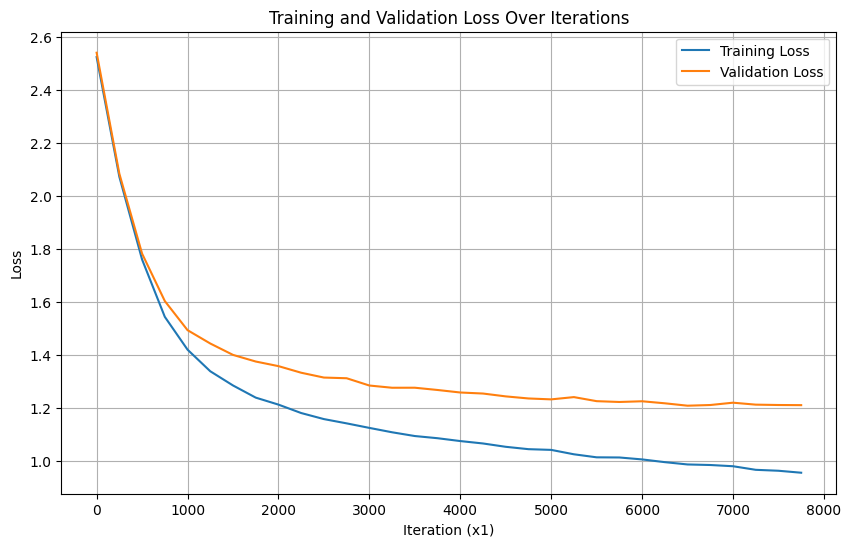

In [26]:
import matplotlib.pyplot as plt

if train_loss_history and val_loss_history:
    plt.figure(figsize=(10, 6))
    plt.plot(iter_history, train_loss_history, label='Training Loss')
    plt.plot(iter_history, val_loss_history, label='Validation Loss')
    plt.xlabel(f'Iteration (x{1})') # Since iter_history stores actual iteration numbers
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No loss history to plot. Did training run?")

## Further Exploration!

**1. Hyperparameter Tuning:**
    *   Experiment with `LEARNING_RATE`, `N_LAYER`, `N_HEAD`, `N_EMBD`, `DROPOUT`. How do these changes affect training speed, final validation loss, and the quality of generated text?
    *   What happens if you significantly increase `MAX_ITERS` (and adjust `EARLY_STOPPING_PATIENCE` if needed)? Can you get a lower validation loss? (Be mindful of Colab time limits).
    *   Try different `temperature` and `top_k` values during generation. How does it change the output?

**7. More Exercises:**
        *   How does weight initialization affect training?
        *   What if you remove positional embeddings?
        *   Can you train on a different small text dataset?



## Bonus: Saving and Loading Your Trained Model

Here's how we can permanently save your model and load it back:

#### Downloading the Model to Your Local Computer

Once training is complete and `best_shakespeare_model.pth` has been saved by the script:

1.  **Locate the File:** In the Colab interface, click on the "Files" icon (looks like a folder) in the left sidebar. You should see `best_shakespeare_model.pth` listed.
2.  **Download:** Right-click on `best_shakespeare_model.pth` and select "Download". The file will be saved to your computer's default downloads folder.

To load this model back into a *new* Colab session (or on your local machine if you have PyTorch set up):
1.  Upload the `.pth` file back to the Colab session (using the "Upload to session storage" button in the Files tab).
2.  Then, in your code, you can load it (make sure your model architecture is defined first):
    ```python
    # # --- Code to define the GPT model and GPTConfig must be run first ---
    # model_config = GPTConfig(vocab_size=vocab_size, ...) # Use the same config as training
    # model = GPT(model_config)
    # model.to(DEVICE)
    #
    # # Load the state dictionary
    # model_path = 'best_shakespeare_model.pth' # Or whatever you named it when uploading
    # if os.path.exists(model_path):
    #     model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    #     model.eval() # Set to evaluation mode
    #     print(f"Model loaded from {model_path}")
    # else:
    #     print(f"Model file not found at {model_path}")
    ```


